# LIBRARIES

In [2]:
import os
import random
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, plot_model
from IPython.display import Audio
from PIL import Image

# VARIABLES

In [3]:
# Variabili utili

IMG_SIZE = (128, 128)
RANDOM_SEED = 69
E = 20
BS = 32

# USED FUNCTIONS

In [4]:
# Funzione per estrarre spettrogrammi mel

def extract_melspectrogram(path, n_mels=128, fmax=8000):
    y, sr = librosa.load(path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

# LOAD DATASET

In [5]:
# Montaggio di Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Path per caricare dataset

# possibili path (o hai il dataset su drive, o nella working directory)
drive_path = Path('/content/drive/MyDrive/Instrument_Classification/mini_dataset_100') # dani (o metti mini_dataset_100 se vuoi usare il mini-dataset)
local_path = Path('./music_dataset') # tommaso

# automaticamente scelgo path esistente
if drive_path.exists():
    DATA_PATH = drive_path
elif local_path.exists():
    DATA_PATH = local_path
else:
    raise FileNotFoundError(
        f"Nessun dataset trovato in {drive_path} né in {local_path}"
    )

# trovo filepaths (lista dei file .wav) e labels (le y)
filepaths = list(DATA_PATH.rglob('*.wav'))
labels = [p.parent.name for p in filepaths]

print(f"Trovati {len(filepaths)} file audio di {len(set(labels))} classi.")
print(f"Classi: {sorted(set(labels))}")

Trovati 2800 file audio di 28 classi.
Classi: ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


# DATA ANALYSIS

In [7]:
# Conteggio audio per classe

counts = Counter(labels)

for classe, count in counts.items():
    print(f"{classe}: {count}")

Shakers: 100
Saxophone: 100
Organ: 100
Ukulele: 100
Tambourine: 100
vibraphone: 100
Trombone: 100
Violin: 100
Trumpet: 100
Piano: 100
Electro_Guitar: 100
Floor_Tom: 100
Mandolin: 100
Drum_set: 100
flute: 100
Harmonium: 100
Keyboard: 100
Harmonica: 100
Hi_Hats: 100
Horn: 100
cowbell: 100
Clarinet: 100
Acoustic_Guitar: 100
Cymbals: 100
Dobro: 100
Bass_Guitar: 100
Banjo: 100
Accordion: 100


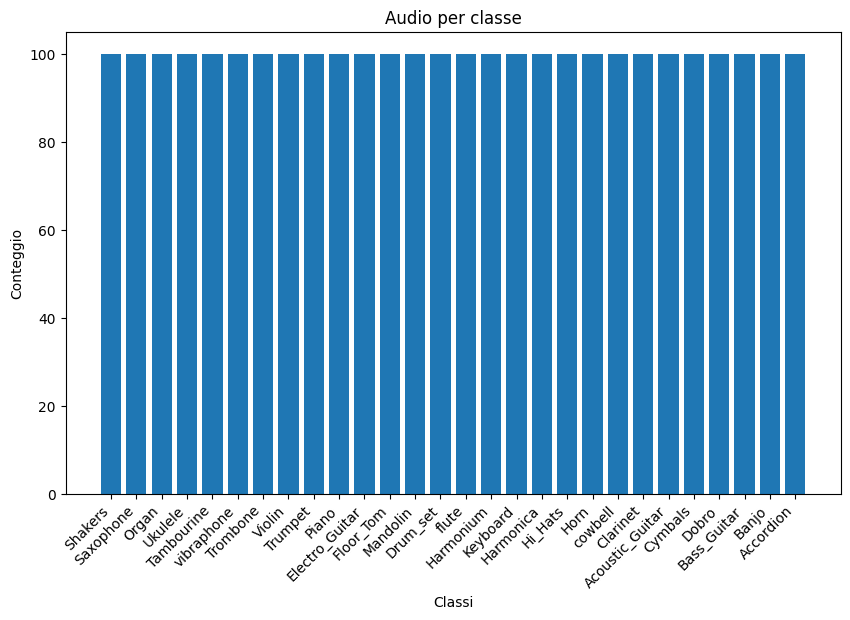

In [8]:
# Plot numero di audio per classe

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.title('Audio per classe')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')
plt.show()

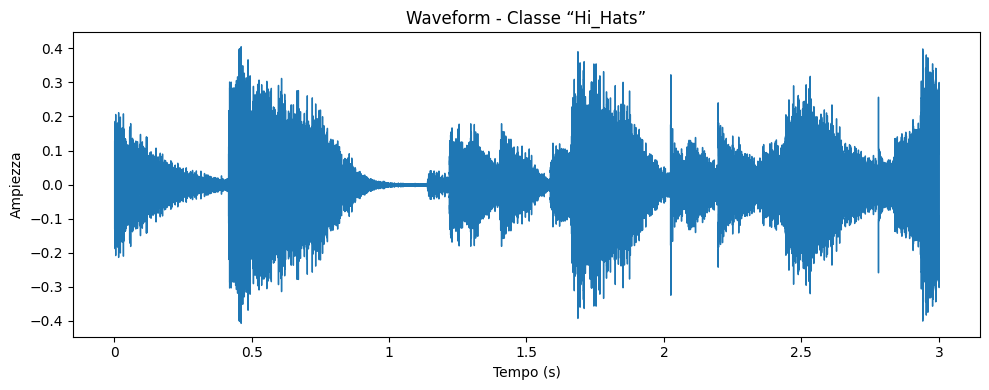

In [9]:
# Visualizzazione e ascolto di un audio random

idx = random.randint(0,len(filepaths)) # indice random
sample_path = filepaths[idx] # audio
sample_label = labels[idx] # label

y, sr = librosa.load(sample_path, sr=None) # load audio
display(Audio(y, rate=sr)) # ascolto

# plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Classe “{sample_label}”")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.tight_layout()
plt.show()

# PREPROCESSING

In [10]:
# Preparazione dataset

X = []
Y = []

for path, label in zip(filepaths, labels):
    try:
        mel = extract_melspectrogram(path)
        img = Image.fromarray(mel).resize(IMG_SIZE)
        img = np.array(img)

        if img.shape != (128, 128):
            continue

        X.append(img)
        Y.append(label)
    except Exception as e:
        print(f"Errore su {path.name}: {e}")

X = np.array(X)
Y = np.array(Y)

In [11]:
# Adattamento X per rete neurale

X = X[..., np.newaxis]

In [12]:
# Standardizzazione

X = X / 255.0

In [13]:
# Forma dati

print('La forma di X è:', X.shape, 'e quella di Y è:', Y.shape)

La forma di X è: (2800, 128, 128, 1) e quella di Y è: (2800,)


In [14]:
# Randomizzazione dati

X, Y = shuffle(X, Y, random_state=RANDOM_SEED)

In [15]:
# Label Encoding

le = LabelEncoder()
Y_encoded = le.fit_transform(Y)
Y_categorical = to_categorical(Y_encoded)

In [22]:
# Prova per capire se l'encoding funziona bene

print(le.classes_)
print(Y_encoded[:10])
print(Y_categorical[:10])

# Spoiler: funziona bene

['Accordion' 'Acoustic_Guitar' 'Banjo' 'Bass_Guitar' 'Clarinet' 'Cymbals'
 'Dobro' 'Drum_set' 'Electro_Guitar' 'Floor_Tom' 'Harmonica' 'Harmonium'
 'Hi_Hats' 'Horn' 'Keyboard' 'Mandolin' 'Organ' 'Piano' 'Saxophone'
 'Shakers' 'Tambourine' 'Trombone' 'Trumpet' 'Ukulele' 'Violin' 'cowbell'
 'flute' 'vibraphone']
[ 6 17  3  7 20 17  7 26  1  2]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [16]:
# Splitting

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_categorical, test_size=0.2, random_state=RANDOM_SEED, stratify=Y)

# MODEL

In [17]:
# Creazione modello

input_shape = X.shape[1:]
num_classes = Y_categorical.shape[1]

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,692 (444.11 KB)

 Trainable params: 113,244 (442.36 KB)

 Non-trainable params: 448 (1.75 KB)

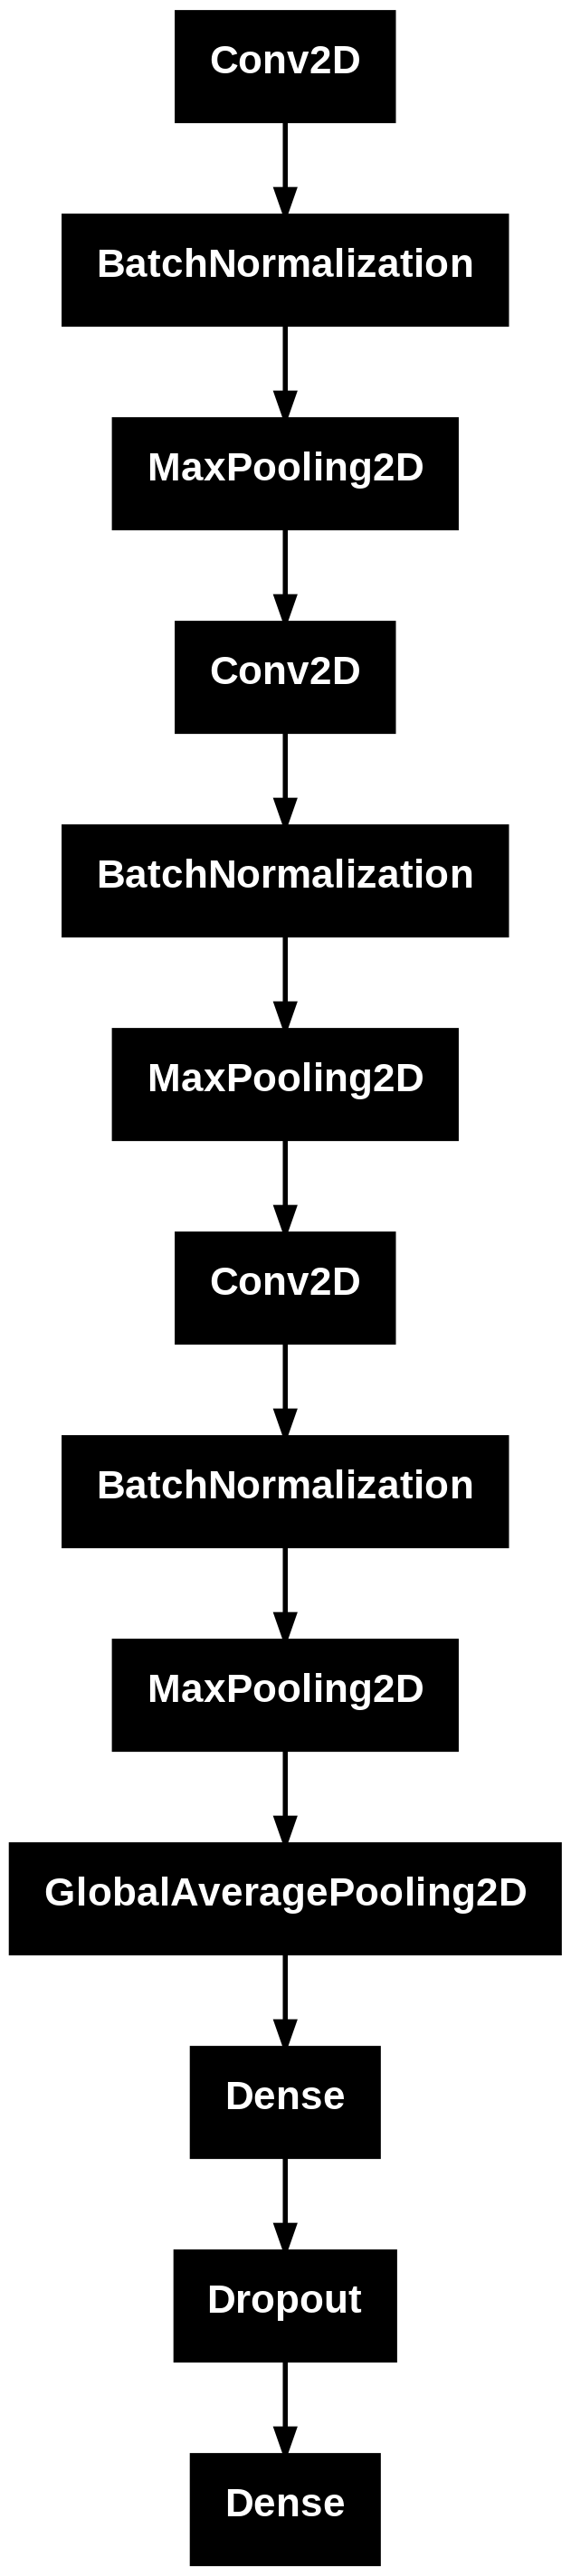

In [18]:
# Plot modello

plot_model(model)

In [19]:
# Addestramento modello

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=E, batch_size=BS)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.1758 - loss: 2.9826 - val_accuracy: 0.0357 - val_loss: 3.4662
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.4291 - loss: 2.0133 - val_accuracy: 0.0357 - val_loss: 3.7574
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4920 - loss: 1.7225 - val_accuracy: 0.0589 - val_loss: 4.0251
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5997 - loss: 1.4124 - val_accuracy: 0.0464 - val_loss: 4.0508
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6421 - loss: 1.2566 - val_accuracy: 0.0393 - val_loss: 3.8597
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.6827 - loss: 1.0791 - val_accuracy: 0.0589 - val_loss: 3.8224
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7294 - loss: 0.9299 - val_accuracy: 0.0661 - val_loss: 4.6290
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7663 - loss: 0.8133 - val_accuracy: 0.0679 - v

# RESULTS

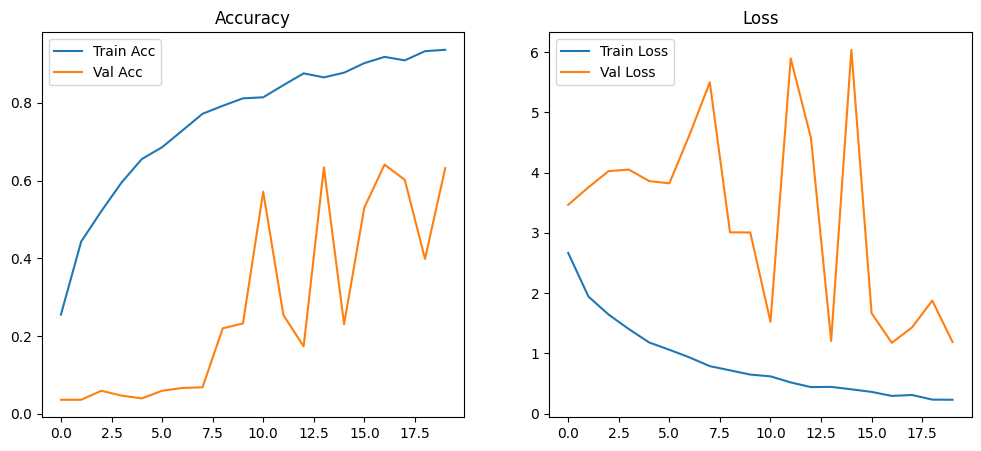

In [20]:
# Visualizzazione risultati

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [21]:
# Valutazione

test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f"Accuracy sul test: {test_acc * 100:.2f}%")

Accuracy sul test: 63.21%
